# Import Modules and Data

In [157]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import ParameterGrid 
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler as lr_sc
import random

import warnings
warnings.filterwarnings("ignore")

import os

os.chdir('C:\\Users\\user\\Krishna\\mncfc_crop_classification')

In [247]:
train = pd.read_csv(r'data_files\data_share\train-3.csv')
test = pd.read_csv(r'data_files\data_share\test-3.csv')
val = pd.read_csv(r'data_files\data_share\val-3.csv')

# Seeding

In [174]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Color class to give color to text
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Predictor and label split

In [160]:
X_train = train.drop('crop_name', axis=1)
y_train = train['crop_name']

X_val = val.drop('crop_name', axis=1)
y_val = val['crop_name']

X_test = test.drop('crop_name', axis=1)
y_test = test['crop_name']

# Scaling

In [161]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)
y_test = pd.get_dummies(y_test)

# Tensor conversion and Torch Data loading

In [162]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = np.zeros((len(y), 1))
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            if len(test_idx) > batch_size:
                test_idx = test_idx[:-(len(test_idx) - batch_size)]
            yield test_idx

    def __len__(self):
        return len(self.y)

## RNN Classifier

In [163]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layers, output_size):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_size = hidden_size
        self.hidden_layers = hidden_layers

        # RNN layers
        self.rnn = nn.RNN(
            input_size, hidden_size, hidden_layers, batch_first=True
        )
        # Fully connected layer
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        
        device = 'cpu'

        x.to(device)
        
        batch_size = x.size(0)
        
        h0 = torch.zeros(self.hidden_layers, batch_size, self.hidden_size).to(device)
        
        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0)
        
        #Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        out = out[:,-1,:]
        out = self.relu(out)
        out = self.fc(out)
        out = self.softmax(out)

        return out

In [213]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, lr_scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.wheat_recall_scores, self.non_wheat_recall_scores = [], []
        self.mod_per_epo = dict()
        self.best_model, self.best_score = None, None
        
    def train_step(self, x, y):
        # zeroes gradients
        self.optimizer.zero_grad()
        
        # Sets model to train mode
        self.model.train()
        
        # Makes predictions
        yhat = self.model(x)
        
#         yhat = torch.reshape(yhat, (y.shape[0],))
        
        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()
        
#         nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        
        # Updates parameters 
        self.optimizer.step()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size, n_epochs=50, n_features=1):
        model_path = r'models\RNN_Wheat_Mustard_binary-1'
        
        device = 'cpu'
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            wheat_recall_scores = []
            non_wheat_recall_scores = []
            
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            self.train_losses.append(np.mean(batch_losses))
            
            with torch.no_grad():
                batch_val_losses = []
                batch_wheat_recall = []
                batch_non_wheat_recall = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    temp_yhat = np.argmax(yhat, axis=1)
                    temp_y_val = np.argmax(y_val, axis=1)
                    precision, recall, f1score, support = score(temp_y_val, temp_yhat, labels=[0,1])
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                    batch_non_wheat_recall.append(recall[0])
                    batch_wheat_recall.append(recall[1])
                self.val_losses.append(np.mean(batch_val_losses))
                self.wheat_recall_scores.append(np.mean(batch_wheat_recall))
                self.non_wheat_recall_scores.append(np.mean(batch_non_wheat_recall))
            
            lr_scheduler.step(self.non_wheat_recall_scores[-1])
            
            self.mod_per_epo[epoch] = [[self.non_wheat_recall_scores[-1], self.wheat_recall_scores[-1]], self.model.state_dict()]

            if (epoch % 10) == 0:
                print(f'     Epoch: [{epoch}/{n_epochs}] Training loss: {round(self.train_losses[-1], 2)} Validation loss: {round(self.val_losses[-1], 2)}  Wheat_recall: {round(self.wheat_recall_scores[-1], 2)} Non_Wheat_recall: {round(self.non_wheat_recall_scores[-1], 2)}')
        
        values = list(self.mod_per_epo.values())
        scores = [row[0] for row in values]
        best_nw_idx = np.argmax(scores, axis=0)[0]
        self.best_score = scores[best_nw_idx]
        self.best_model = values[best_nw_idx][1]
        
#         torch.save(best_model, model_path)
        
    def plot_losses(self):
        plt.figure(figsize=(20,5))
        plt.subplot(1,2,1)
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.grid()
        plt.title("Losses")
        plt.subplot(1,2,2)
        plt.plot(self.non_wheat_recall_scores, label="Non_Wheat Recall")
        plt.plot(self.wheat_recall_scores, label="Wheat Recall")
        plt.legend()
        plt.grid()
        plt.title("Recall_Scores")
        plt.show()
        plt.close()

In [233]:
fort_nights = list(X_train.loc[:, 'oct_2f':'apr_1f'].columns)

batch_size = 8
n_epochs = 20
learning_rate = 1e-2
best_scores = []
best_models = []
best_params = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    recall_scores = []
    all_models = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
        
    temp_X_train = X_train.drop(drop_cols, axis=1)
    temp_X_val = X_val.drop(drop_cols, axis=1)
    
    temp_train = TensorDataset(torch.Tensor(temp_X_train.values), torch.Tensor(y_train.values))
    temp_val = TensorDataset(torch.Tensor(temp_X_val.values), torch.Tensor(y_val.values))

    train_sampler = StratifiedBatchSampler(y_train[1].values, batch_size=batch_size)
    val_sampler = StratifiedBatchSampler(y_val[1].values, batch_size=batch_size)

    train_loader = DataLoader(temp_train, batch_sampler=train_sampler)
    val_loader = DataLoader(temp_val, batch_sampler=val_sampler)
    
    param_grid = list(ParameterGrid({'input_size':[temp_X_train.shape[1]],
                                'hidden_size':[2**i for i in range(2,7)], 
                                'hidden_layers':np.arange(1, 4, 1),
                                'output_size':[y_train.shape[1]]}))
    
    fns_used.append('-'.join(temp_X_train.columns[[0,-1]]))
    print(color.PURPLE + color.BOLD + f'{len(fns_used)}. Validation for {fns_used[-1]} started' + color.END)
    print()
    for p in param_grid:
        print(color.GREEN + color.BOLD + f' {param_grid.index(p)+1}. Training for {p} combination' + color.END)
        print()
        model = RNNModel(**p)
        model.to('cpu')
        loss_fn = nn.CrossEntropyLoss(reduction='mean')
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        lr_scheduler = lr_sc.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1)
        opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, lr_scheduler=lr_scheduler)
        opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=p['input_size'])
        recall_scores.append(opt.best_score)
        all_models.append(opt.best_model)
        print()
        
    recall_scores = np.array(recall_scores)
    max_nw_idx = np.argmax(recall_scores, axis=0)[0]
    best_scores.append(recall_scores[max_nw_idx])
    best_models.append(all_models[max_nw_idx])
    best_params.append(param_grid[max_nw_idx])
    
    print(color.BLUE+color.BOLD+f'==> {fns_used[-1]} validation completed with best recall of {best_scores[-1]}'+color.END)
    print()
    
    i += 1
    
print('Done!!')

1. Validation for oct_2f-apr_1f started

 1. Training for {'hidden_layers': 1, 'hidden_size': 4, 'input_size': 12, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.97
     Epoch: [20/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.98

 2. Training for {'hidden_layers': 1, 'hidden_size': 8, 'input_size': 12, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.98
     Epoch: [20/20] Training loss: 0.33 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.98

 3. Training for {'hidden_layers': 1, 'hidden_size': 16, 'input_size': 12, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.97
     Epoch: [20/20] Training loss: 0.33 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.97

 4. Traini

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 1.0
     Epoch: [20/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.99

 11. Training for {'hidden_layers': 3, 'hidden_size': 4, 'input_size': 11, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.99
     Epoch: [20/20] Training loss: 0.35 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.98

 12. Training for {'hidden_layers': 3, 'hidden_size': 8, 'input_size': 11, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.98
     Epoch: [20/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.98

 13. Training for {'hidden_layers': 3, 'hidden_size': 16, 'input_size': 11, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.35 Validatio

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.33  Wheat_recall: 0.98 Non_Wheat_recall: 0.99
     Epoch: [20/20] Training loss: 0.33 Validation loss: 0.33  Wheat_recall: 0.98 Non_Wheat_recall: 0.98

 5. Training for {'hidden_layers': 1, 'hidden_size': 64, 'input_size': 9, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.97
     Epoch: [20/20] Training loss: 0.33 Validation loss: 0.33  Wheat_recall: 0.98 Non_Wheat_recall: 0.98

 6. Training for {'hidden_layers': 2, 'hidden_size': 4, 'input_size': 9, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.98
     Epoch: [20/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.98

 7. Training for {'hidden_layers': 2, 'hidden_size': 8, 'input_size': 9, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation los

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.99
     Epoch: [20/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.99

 15. Training for {'hidden_layers': 3, 'hidden_size': 64, 'input_size': 8, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.35 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.97
     Epoch: [20/20] Training loss: 0.35 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.98

==> oct_2f-feb_1f validation completed with best recall of [1.         0.93489097]

6. Validation for oct_2f-jan_2f started

 1. Training for {'hidden_layers': 1, 'hidden_size': 4, 'input_size': 7, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.34 Validation loss: 0.35  Wheat_recall: 0.95 Non_Wheat_recall: 1.0
     Epoch: [20/20] Training loss: 0.34 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.99

 2. Training for {'hidden_layers'

     Epoch: [10/20] Training loss: 0.35 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.98
     Epoch: [20/20] Training loss: 0.35 Validation loss: 0.35  Wheat_recall: 0.97 Non_Wheat_recall: 0.97

 9. Training for {'hidden_layers': 2, 'hidden_size': 32, 'input_size': 6, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.35 Validation loss: 0.35  Wheat_recall: 0.95 Non_Wheat_recall: 0.98
     Epoch: [20/20] Training loss: 0.35 Validation loss: 0.35  Wheat_recall: 0.97 Non_Wheat_recall: 0.98

 10. Training for {'hidden_layers': 2, 'hidden_size': 64, 'input_size': 6, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.36 Validation loss: 0.34  Wheat_recall: 0.99 Non_Wheat_recall: 0.93
     Epoch: [20/20] Training loss: 0.35 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.95

 11. Training for {'hidden_layers': 3, 'hidden_size': 4, 'input_size': 6, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.62 Validation 

     Epoch: [10/20] Training loss: 0.36 Validation loss: 0.35  Wheat_recall: 0.98 Non_Wheat_recall: 0.96
     Epoch: [20/20] Training loss: 0.36 Validation loss: 0.35  Wheat_recall: 0.98 Non_Wheat_recall: 0.95

 3. Training for {'hidden_layers': 1, 'hidden_size': 16, 'input_size': 4, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.36 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.95
     Epoch: [20/20] Training loss: 0.36 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.95

 4. Training for {'hidden_layers': 1, 'hidden_size': 32, 'input_size': 4, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.36 Validation loss: 0.34  Wheat_recall: 0.98 Non_Wheat_recall: 0.96
     Epoch: [20/20] Training loss: 0.36 Validation loss: 0.34  Wheat_recall: 0.97 Non_Wheat_recall: 0.96

 5. Training for {'hidden_layers': 1, 'hidden_size': 64, 'input_size': 4, 'output_size': 2} combination

     Epoch: [10/20] Training loss: 0.36 Validation l

In [241]:
def evaluate(model, test_loader, batch_size, n_features):

    device = 'cpu'

    with torch.no_grad():
        batch_wheat_recall = []
        batch_non_wheat_recall = []
#             y_pred = []
        for x_test, y_test in test_loader:
            x_test = x_test.view([batch_size, -1, n_features]).to(device)
            y_test = y_test.to(device)
            model.eval()
            yhat = model(x_test)
#             display(yhat, y_test.argmax(axis=1))
            yhat = np.argmax(yhat, axis=1)
            y_test = np.argmax(y_test, axis=1)
            precision, recall, f1score, support = score(y_test, yhat, labels=[0,1])
#             print(recall)
            batch_wheat_recall.append(recall[1])
            batch_non_wheat_recall.append(recall[0])
#                 y_pred.append(yhat)

    return [np.mean(batch_non_wheat_recall), np.mean(batch_wheat_recall)]


test_recall_scores = []

for i in range(len(fns_used)):
    model = RNNModel(**best_params[i])
    model.load_state_dict(best_models[i])
    strt_fn, end_fn = fns_used[i].split('-') 
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    temp_test = TensorDataset(torch.Tensor(temp_X_test.values), torch.Tensor(y_test.values))
    test_sampler = StratifiedBatchSampler(y_test[1].values, batch_size=batch_size)
    test_loader = DataLoader(temp_test, batch_sampler=test_sampler)
    test_recall_scores.append(evaluate(model, test_loader, batch_size, best_params[i]['input_size']))
    print(test_recall_scores[i])
    
test_scores = pd.DataFrame({'Fortnites Used':fns_used, 'Mustard':np.array(test_recall_scores)[:,0], 'Wheat':np.array(test_recall_scores)[:,1]})
test_scores

[0.8574969021065675, 0.9058904230837315]
[0.8599752168525403, 0.9487962471233848]
[0.8612143742255266, 0.9622720835546115]
[0.862453531598513, 0.9693308550185874]
[0.862453531598513, 0.9680031864046734]
[0.8599752168525403, 0.966786156841919]
[0.8599752168525403, 0.9145202690741724]
[0.8612143742255266, 0.9167551779075944]
[0.8587360594795539, 0.9213577624358292]


,Fortnites Used,Mustard,Wheat
0,oct_2f-apr_1f,0.857497,0.905890
1,oct_2f-mar_2f,0.859975,0.948796
2,oct_2f-mar_1f,0.861214,0.962272
3,oct_2f-feb_2f,0.862454,0.969331
4,oct_2f-feb_1f,0.862454,0.968003
5,oct_2f-jan_2f,0.859975,0.966786
6,oct_2f-jan_1f,0.859975,0.914520
7,oct_2f-dec_2f,0.861214,0.916755
8,oct_2f-dec_1f,0.858736,0.921358


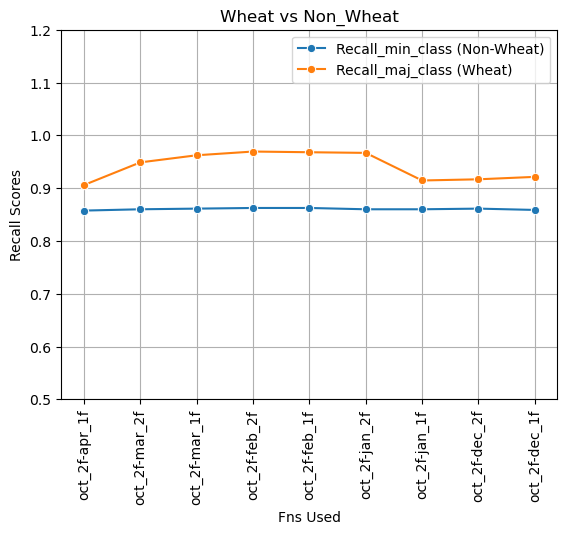

In [242]:
sns.lineplot(y=np.array(test_recall_scores)[:,0], x=fns_used, label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,1], x=fns_used, label='Recall_maj_class (Wheat)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()